<a href="https://colab.research.google.com/github/annykay/NoiseInDataImpact/blob/main/GaussianNoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Noise

In [ ]:
# Imports

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsOneClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error, accuracy_score, f1_score

from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler

import time
from tqdm import tqdm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
DATASETS = [
    {
        'name': 'Pulsars',
        'features': 'Datasets/Pulsars_features.csv',
        'labels': 'Datasets/Pulsars_labels.csv'
    },
#     {
#         'name': 'Rice',
#         'features': 'Datasets/Rice_features.csv',
#         'labels': 'Datasets/Rice_labels.csv'
#     },
#     {
#         'name': 'Stellar',
#         'features': 'Datasets/StellarFeatures.csv',
#         'labels': 'Datasets/StellarLabels.csv'
#     },
#     {
#         'name': 'Stellar',
#         'features': 'Datasets/stellar_features.csv',
#         'labels': 'Datasets/stellar_labels.csv'
#     },
#     {
#         'name': 'Bank',
#         'features': 'Datasets/bank_data_features.csv',
#         'labels': 'Datasets/bank_data_labels.csv'
#     },
]

clfs = {
    'DTC': DecisionTreeClassifier,
    'RFC': RandomForestClassifier,
    'LTC': LogisticRegression,
    'XGB': XGBClassifier,
    'KNC': KNeighborsClassifier,
}

grd_pars = {
    'max_depth': [5, 8, 15, 30],
    'criterion': ['gini', 'entropy'],
    'max_features': [2, 5, 8, 12, 16, 20, 25, None],
    'n_estimators': [20, 40, 60, 80],
    'n_neighbors': [1, 3, 6, 9, 12, 15],
    'learning_rate': [0.1, 0.3, 0.5, 0.7, 1],
    'C': [ 0.5, 1, 5, 10 ],
}

mdl_pars = [
     ['max_depth', 'criterion'],
     ['max_depth', 'max_features', 'n_estimators'],
     ['C',],
     ['max_depth', 'n_estimators', 'learning_rate'],
     ['n_neighbors',],
]

In [ ]:
def scale_data(X):
    nc_cols = non_categorical(X)
    sc = StandardScaler()
    X_s = pd.DataFrame(sc.fit_transform(X[nc_cols]), columns=nc_cols)
    return X_s

def best_params(X, y, clf, grid):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=0xC0FFEE)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.20, random_state=0xC0FFEE)

    val_fold = 1 - 2*np.isin(X_train_val, X_val).all(axis=1).astype(int)
    ps = PredefinedSplit(val_fold)
    
    grd_clf = GridSearchCV(clf(), grid,
                  scoring = 'f1_micro', cv = ps, n_jobs=-1)

    grd_clf.fit(X_train_val, y_train_val)
    y_train_pred = grd_clf.best_estimator_.predict(X_train)

    grd_clf.best_estimator_.fit(X_train, y_train)
    y_test_pred = grd_clf.best_estimator_.predict(X_test)

    train_score = round(f1_score(y_train, y_train_pred, average='weighted'), 2)
    test_score = round(f1_score(y_test, y_test_pred, average='weighted'), 2)
    
    return train_score, test_score, grd_clf.best_params_

mdl_vals = {}

names, models = list(clfs.keys()), list(clfs.values())
for model, clf, params in tqdm(zip(names, models, mdl_pars), total=len(mdl_pars)):
    mdl_vals[model] = {key: [] for key in params}
    for DATA in DATASETS:
        X = pd.read_csv(DATA['features'])
        y = pd.read_csv(DATA['labels'])
        
        X_s = scale_data(X)

        grid = { key: grd_pars[key] for key in params }
        train_score, test_score, parameters = best_params(X_s, y, clf, grid)
        
        print(model, DATA['name'], train_score, test_score)
        print(parameters)
        
        for key in parameters:
            mdl_vals[model][key].append(parameters[key])
        
print(mdl_vals)



In [ ]:
# mdl_vals = {
#      'DTC': {
#          'max_depth': [2, 5, 8, 4],
#          'criterion': ['entropy', 'entropy', 'entropy', 'entropy']
#      },
#      'RFC': {
#          'max_depth': [7, 5, 8, None],
#          'max_features': [6, 8, 2, 'auto'],
#          'n_estimators': [10, 20, 40, 5],
#          'n_jobs': [-1, -1, -1, -1],
#      },
#      'LTC': {
#          'C': [12, 10, 0.5, 1],
#          'n_jobs': [-1, -1, -1, -1],
#      },
#      'XGB': {
#          'max_depth': [2, 15, 5, None],
#          'n_estimators': [70, 80, 80, 100],
#          'learning_rate': [0.3, 0.7, 0.1, 1],
#          'verbosity': [0, 3, 15, 0],
#          'n_jobs': [-1, -1, -1, -1],
#      },
#      'KNC': {
#          'n_neighbors': [9, 3, 15, 5],
#          'n_jobs': [-1, -1, -1, -1],
#      },
# }

mdl_vals = {
     'DTC': {
         'max_depth': [2, 5, 9, 4],
         'criterion': ['entropy', 'entropy', 'entropy', 'entropy']
     },
     'RFC': {
         'max_depth': [7, 5, 14, None],
         'max_features': [6, 5, 'auto', 'auto'],
         'n_estimators': [10, 30, 90, 5],
         'n_jobs': [-1, -1, -1, -1],
     },
     'LTC': {
         'C': [12, 1, 2010, 1],
         'n_jobs': [-1, -1, -1, -1],
     },
     'XGB': {
         'max_depth': [2, 5, 12, None],
         'n_estimators': [70, 30, 100, 100],
         'learning_rate': [0.3, 1, 0.1, 1],
         'verbosity': [0 ,0, 0, 0],
         'n_jobs': [-1, -1, -1, -1],
     },
     'KNC': {
         'n_neighbors': [9, 5, 3, 5],
         'n_jobs': [-1, -1, -1, -1],
     },
}



def label_classes(dataset):
    col = dataset.columns[0]
    return dataset[col].unique()
    
def non_categorical(dataset):
    features = []
    for col in dataset.columns:
        vals = np.sort(dataset[col].unique())
        if np.any(vals != np.array([0,1])):
            features.append(col)
    return features
    
def gaussian_noise(data, features, level):
    new_data = data.copy()
    for col in features:
        mean = new_data[col].mean()
        std = new_data[col].std()
        new_data[col] += level * mean * np.random.normal(0, 5, size=len(data))
    return new_data

def scale_data(X):
    nc_cols = non_categorical(X)
    sc = StandardScaler()
    X_s = pd.DataFrame(sc.fit_transform(X[nc_cols]), columns=nc_cols)
    return X_s

In [ ]:
# Loading preproceed data

rice_features = pd.read_csv('Rice_features.csv').drop('Unnamed: 0', axis=1)
rice_labels = pd.read_csv('Rice_labels.csv').drop('Unnamed: 0', axis=1)

In [ ]:
# Models

clfs = {
    'DTC': DecisionTreeClassifier(max_depth=5),
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=30, max_features=5),
    'LTC': LogisticRegression(C=1),
    'XGB': XGBClassifier(max_depth=5, n_estimators=30),
    'KNC': KNeighborsClassifier(n_neighbors=5)
}

In [ ]:
def gaussian_noise(data, features, level):
    new_data = data.copy()
    for col in features:
        mean = new_data[col].mean()
        std = new_data[col].std()
        new_data[col] += level * mean * np.random.normal(0, 5, size=len(data))
    return new_data

In [ ]:
SCORES = { data['name']: { mdl: [] for mdl in clfs.keys() } for data in DATASETS }

names, models = list(clfs.keys()), list(clfs.values())
for model, clf, params in tqdm(zip(names, models, mdl_pars), total=len(clfs.keys())):
    for ind, DATA in enumerate(DATASETS):
        X = pd.read_csv(DATA['features'])
        y = pd.read_csv(DATA['labels'])
        
        args = {par: mdl_vals[model][par][ind] for par in params}
        average = 'micro'
        mdl = clf(**args)
        if len(label_classes(y)) > 2:
            mdl = OneVsOneClassifier(mdl)
        
        for i in range(10):
            level = i/10
        
            features = non_categorical(X)
            
#             features = important_features(X, y, 2, mdl_vals)
            X_n = gaussian_noise(X, features, level)
            X_s = scale_data(X_n)
            
        
            X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.3, random_state=0)
        
            mdl.fit(X_test, y_test)
            y_pred = mdl.predict(X_test)
            score = round(f1_score(y_test, y_pred, average=average), 2)
            
            SCORES[DATA['name']][model].append(score)
        print(DATA['name'], SCORES[DATA['name']][model])
        

print(SCORES)

  0%|          | 0/5 [00:00<?, ?it/s]

Pulsars [0.98, 0.97, 0.97, 0.96, 0.95, 0.95, 0.95, 0.94, 0.94, 0.94]
Rice [0.99, 0.72, 0.64, 0.61, 0.59, 0.59, 0.58, 0.58, 0.58, 0.57]
Stellar [0.99, 0.75, 0.64, 0.58, 0.53, 0.52, 0.5, 0.47, 0.46, 0.45]


 20%|██        | 1/5 [00:11<00:45, 11.45s/it]

Bank [0.91, 0.9, 0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89]
Pulsars [0.99, 0.99, 0.98, 0.98, 0.98, 0.97, 0.97, 0.96, 0.96, 0.95]
Rice [0.99, 0.78, 0.68, 0.67, 0.64, 0.63, 0.63, 0.64, 0.62, 0.64]
Stellar [1.0, 0.94, 0.91, 0.91, 0.92, 0.92, 0.92, 0.9, 0.91, 0.93]


 40%|████      | 2/5 [01:45<01:48, 36.19s/it]

Bank [0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98]
Pulsars [0.98, 0.97, 0.97, 0.96, 0.96, 0.95, 0.95, 0.95, 0.94, 0.94]
Rice [0.99, 0.74, 0.63, 0.6, 0.57, 0.56, 0.56, 0.55, 0.55, 0.56]
Stellar [0.96, 0.7, 0.58, 0.53, 0.49, 0.46, 0.44, 0.43, 0.42, 0.41]


 60%|██████    | 3/5 [01:51<00:54, 27.19s/it]

Bank [0.91, 0.9, 0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89]
Pulsars [0.99, 0.98, 0.98, 0.97, 0.97, 0.96, 0.96, 0.96, 0.95, 0.95]
Rice [1.0, 0.92, 0.86, 0.86, 0.86, 0.86, 0.84, 0.85, 0.85, 0.86]
Stellar [1.0, 0.99, 0.99, 0.99, 0.99, 0.98, 0.98, 0.98, 0.98, 0.99]


 80%|████████  | 4/5 [04:03<00:58, 58.73s/it]

Bank [0.97, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Pulsars [0.98, 0.97, 0.97, 0.96, 0.96, 0.95, 0.94, 0.94, 0.94, 0.94]
Rice [0.99, 0.81, 0.72, 0.71, 0.7, 0.7, 0.69, 0.69, 0.7, 0.69]
Stellar [0.96, 0.79, 0.74, 0.7, 0.68, 0.67, 0.66, 0.64, 0.64, 0.64]


100%|██████████| 5/5 [05:48<00:00, 69.60s/it]

Bank [0.92, 0.91, 0.91, 0.9, 0.9, 0.9, 0.89, 0.89, 0.9, 0.89]
{'Pulsars': {'DTC': [0.98, 0.97, 0.97, 0.96, 0.95, 0.95, 0.95, 0.94, 0.94, 0.94], 'RFC': [0.99, 0.99, 0.98, 0.98, 0.98, 0.97, 0.97, 0.96, 0.96, 0.95], 'LTC': [0.98, 0.97, 0.97, 0.96, 0.96, 0.95, 0.95, 0.95, 0.94, 0.94], 'XGB': [0.99, 0.98, 0.98, 0.97, 0.97, 0.96, 0.96, 0.96, 0.95, 0.95], 'KNC': [0.98, 0.97, 0.97, 0.96, 0.96, 0.95, 0.94, 0.94, 0.94, 0.94]}, 'Rice': {'DTC': [0.99, 0.72, 0.64, 0.61, 0.59, 0.59, 0.58, 0.58, 0.58, 0.57], 'RFC': [0.99, 0.78, 0.68, 0.67, 0.64, 0.63, 0.63, 0.64, 0.62, 0.64], 'LTC': [0.99, 0.74, 0.63, 0.6, 0.57, 0.56, 0.56, 0.55, 0.55, 0.56], 'XGB': [1.0, 0.92, 0.86, 0.86, 0.86, 0.86, 0.84, 0.85, 0.85, 0.86], 'KNC': [0.99, 0.81, 0.72, 0.71, 0.7, 0.7, 0.69, 0.69, 0.7, 0.69]}, 'Stellar': {'DTC': [0.99, 0.75, 0.64, 0.58, 0.53, 0.52, 0.5, 0.47, 0.46, 0.45], 'RFC': [1.0, 0.94, 0.91, 0.91, 0.92, 0.92, 0.92, 0.9, 0.91, 0.93], 'LTC': [0.96, 0.7, 0.58, 0.53, 0.49, 0.46, 0.44, 0.43, 0.42, 0.41], 'XGB': [1.0, 0

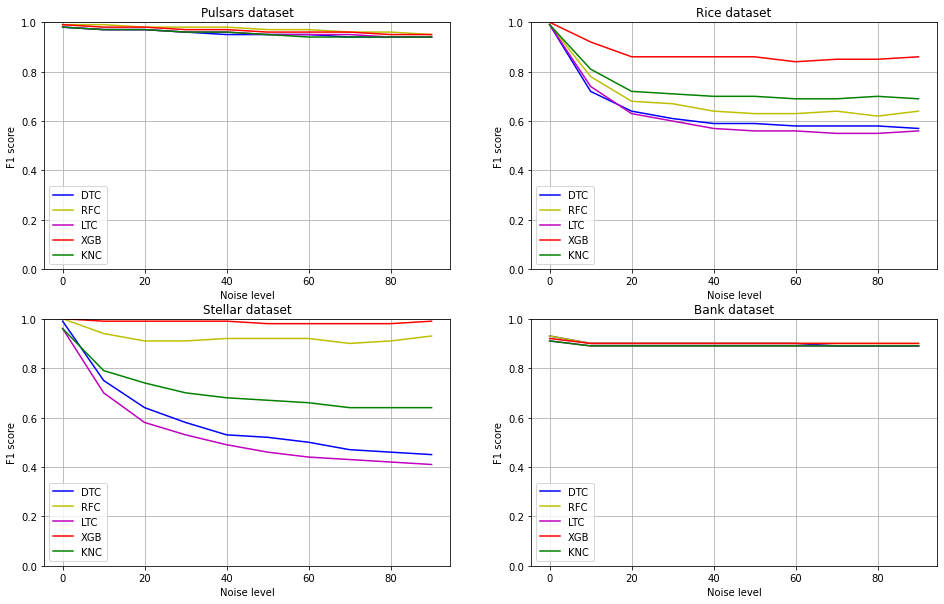

In [ ]:
SCORES = {
    'Pulsars': {
        'DTC': [0.98, 0.97, 0.97, 0.96, 0.95, 0.95, 0.95, 0.94, 0.94, 0.94],
        'RFC': [0.99, 0.99, 0.98, 0.98, 0.98, 0.97, 0.97, 0.96, 0.96, 0.95],
        'LTC': [0.98, 0.97, 0.97, 0.96, 0.96, 0.95, 0.95, 0.95, 0.94, 0.94],
        'XGB': [0.99, 0.98, 0.98, 0.97, 0.97, 0.96, 0.96, 0.96, 0.95, 0.95],
        'KNC': [0.98, 0.97, 0.97, 0.96, 0.96, 0.95, 0.94, 0.94, 0.94, 0.94]
    },
    'Rice': {
        'DTC': [0.99, 0.72, 0.64, 0.61, 0.59, 0.59, 0.58, 0.58, 0.58, 0.57],
        'RFC': [0.99, 0.78, 0.68, 0.67, 0.64, 0.63, 0.63, 0.64, 0.62, 0.64],
        'LTC': [0.99, 0.74, 0.63, 0.6, 0.57, 0.56, 0.56, 0.55, 0.55, 0.56],
        'XGB': [1.0, 0.92, 0.86, 0.86, 0.86, 0.86, 0.84, 0.85, 0.85, 0.86],
        'KNC': [0.99, 0.81, 0.72, 0.71, 0.7, 0.7, 0.69, 0.69, 0.7, 0.69]
    },
    'Stellar': {
        'DTC': [0.99, 0.75, 0.64, 0.58, 0.53, 0.52, 0.5, 0.47, 0.46, 0.45],
        'RFC': [1.0, 0.94, 0.91, 0.91, 0.92, 0.92, 0.92, 0.9, 0.91, 0.93],
        'LTC': [0.96, 0.7, 0.58, 0.53, 0.49, 0.46, 0.44, 0.43, 0.42, 0.41],
        'XGB': [1.0, 0.99, 0.99, 0.99, 0.99, 0.98, 0.98, 0.98, 0.98, 0.99],
        'KNC': [0.96, 0.79, 0.74, 0.7, 0.68, 0.67, 0.66, 0.64, 0.64, 0.64]
    },
    'Bank': {
        'DTC': [0.93, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.89, 0.89, 0.89],
        'RFC': [0.93, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
        'LTC': [0.91, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89],
        'XGB': [0.92, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
        'KNC': [0.91, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89]
    }
}

fig, axs = plt.subplots(2,2, figsize=(16,10))

colors = ['b', 'y', 'm', 'r', 'g']

for DATA, ax in zip(DATASETS, axs.flatten()):
    for model, c in zip(clfs.keys(), colors):
        ax.plot(np.arange(0, 100, 10), SCORES[DATA['name']][model], label=model, c=c)
        ax.set_title(DATA['name'] + ' dataset')
        ax.grid()
        ax.legend()
        ax.set_ylim(0,1)
        ax.set_ylabel('F1 score')
        ax.set_xlabel('Noise level')

plt.legend()

In [ ]:
def important_features(X, y, num, prmtrs, i):
    non_cat = non_categorical(X)
    col_inds = [ X.columns.get_loc(col) for col in non_cat ]
    
    rfc_args = { par: prmtrs['RFC'][par][i] for par in prmtrs['RFC'].keys() }
    
    rfc = RandomForestClassifier(**rfc_args).fit(X, y)
    vals = [ rfc.feature_importances_[ind] for ind in col_inds ]
    inds = np.argpartition(vals, len(vals) - num)[-num:]
    features = [ non_cat[ind] for ind in inds ]
    
    return features

def feature_importances(X, y, prmtrs):
    rfc_args = { par: prmtrs['RFC'][par][i] for par in prmtrs['RFC'].keys() }
    rfc = RandomForestClassifier(**rfc_args).fit(X, y)
    vals = rfc.feature_importances_
    
    importances = { col: vals[n] for n, col in enumerate(X.columns) }
    
    return importances
    

SCORES_imp = { data['name']: { mdl: [] for mdl in clfs.keys() } for data in DATASETS }

names, models = list(clfs.keys()), list(clfs.values())
for model, clf, params in tqdm(zip(names, models, mdl_pars), total=len(clfs.keys())):
    for ind, DATA in enumerate(DATASETS):
        X = pd.read_csv(DATA['features'])
        y = pd.read_csv(DATA['labels'])
        
        args = {par: mdl_vals[model][par][ind] for par in params}
        average = 'micro'
        mdl = clf(**args)
        if len(label_classes(y)) > 2:
            mdl = OneVsOneClassifier(mdl)
        
        for i in range(10):
            level = i/10
        
#             features = non_categorical(X)
            features = important_features(X, y, 2, mdl_vals, ind)
    
            X_n = gaussian_noise(X, features, level)
            X_s = scale_data(X_n)
        
            X_train, X_test, y_train, y_test = train_test_split(X_s, y, test_size=0.3, random_state=0)
        
            mdl.fit(X_train, y_train)
            y_pred = mdl.predict(X_test)
            score = round(f1_score(y_test, y_pred, average=average), 2)
            
            SCORES_imp[DATA['name']][model].append(score)

print(SCORES_imp)

100%|██████████| 5/5 [14:31<00:00, 174.30s/it]

{'Pulsars': {'DTC': [0.98, 0.97, 0.97, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96], 'RFC': [0.98, 0.98, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97], 'LTC': [0.98, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97], 'XGB': [0.98, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97], 'KNC': [0.98, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97]}, 'Rice': {'DTC': [0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'RFC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'LTC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'XGB': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'KNC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]}, 'Stellar': {'DTC': [0.97, 0.85, 0.84, 0.83, 0.82, 0.81, 0.81, 0.81, 0.8, 0.8], 'RFC': [0.98, 0.9, 0.88, 0.87, 0.86, 0.86, 0.85, 0.85, 0.84, 0.84], 'LTC': [0.96, 0.8, 0.75, 0.73, 0.72, 0.7, 0.7, 0.7, 0.7, 0.7], 'XGB': [0.98, 0.91, 0.89, 0.88, 0.87, 0.86, 0.86, 0.86, 0.86, 0.86], 'KNC': 

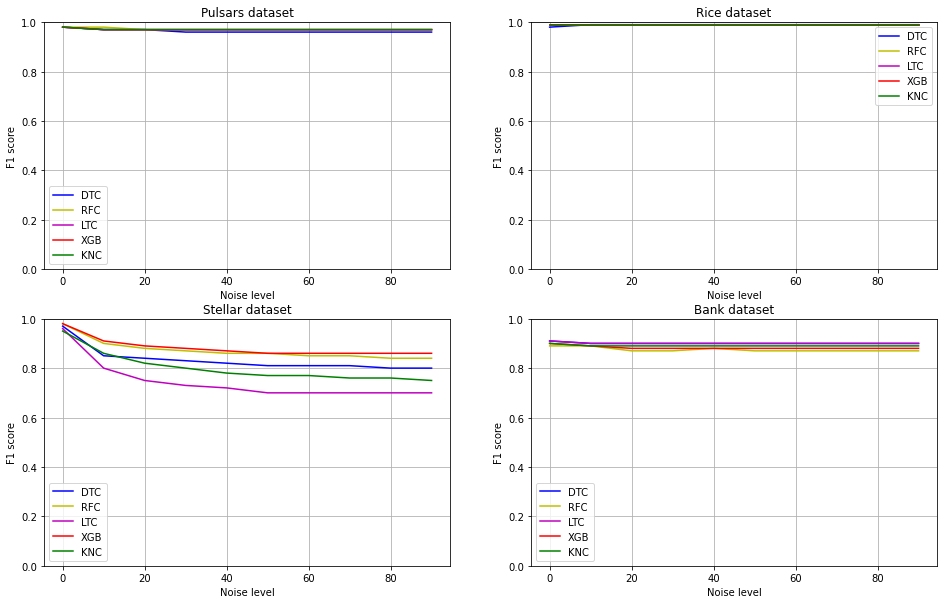

In [ ]:
# SCORES_imp = {'Pulsars': {'DTC': [0.98, 0.98, 0.98, 0.98, 0.98, 0.97, 0.97, 0.97, 0.97, 0.97], 'RFC': [0.98, 0.97, 0.98, 0.98, 0.98, 0.97, 0.97, 0.97, 0.97, 0.97], 'LTC': [0.98, 0.98, 0.98, 0.98, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97], 'XGB': [0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.97, 0.97, 0.97, 0.97], 'KNC': [0.98, 0.98, 0.98, 0.97, 0.98, 0.97, 0.97, 0.97, 0.97, 0.97]}, 'Rice': {'DTC': [0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'RFC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'LTC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'XGB': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'KNC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]}, 'Stellar': {'DTC': [0.97, 0.93, 0.91, 0.89, 0.88, 0.86, 0.84, 0.83, 0.84, 0.84], 'RFC': [0.98, 0.95, 0.94, 0.92, 0.91, 0.9, 0.9, 0.89, 0.89, 0.88], 'LTC': [0.96, 0.91, 0.87, 0.85, 0.83, 0.81, 0.8, 0.78, 0.78, 0.77], 'XGB': [0.98, 0.95, 0.94, 0.93, 0.92, 0.92, 0.91, 0.9, 0.9, 0.9], 'KNC': [0.95, 0.92, 0.9, 0.89, 0.88, 0.86, 0.86, 0.84, 0.84, 0.83]}, 'Bank': {'DTC': [0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9], 'RFC': [0.88, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87, 0.87], 'LTC': [0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9], 'XGB': [0.9, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88], 'KNC': [0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89]}}

SCORES_imp = {'Pulsars': {'DTC': [0.98, 0.97, 0.97, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96], 'RFC': [0.98, 0.98, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97], 'LTC': [0.98, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97], 'XGB': [0.98, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97], 'KNC': [0.98, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97, 0.97]}, 'Rice': {'DTC': [0.98, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'RFC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'LTC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'XGB': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99], 'KNC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]}, 'Stellar': {'DTC': [0.97, 0.85, 0.84, 0.83, 0.82, 0.81, 0.81, 0.81, 0.8, 0.8], 'RFC': [0.98, 0.9, 0.88, 0.87, 0.86, 0.86, 0.85, 0.85, 0.84, 0.84], 'LTC': [0.96, 0.8, 0.75, 0.73, 0.72, 0.7, 0.7, 0.7, 0.7, 0.7], 'XGB': [0.98, 0.91, 0.89, 0.88, 0.87, 0.86, 0.86, 0.86, 0.86, 0.86], 'KNC': [0.95, 0.86, 0.82, 0.8, 0.78, 0.77, 0.77, 0.76, 0.76, 0.75]}, 'Bank': {'DTC': [0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9], 'RFC': [0.89, 0.89, 0.87, 0.87, 0.88, 0.87, 0.87, 0.87, 0.87, 0.87], 'LTC': [0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9], 'XGB': [0.9, 0.89, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88], 'KNC': [0.9, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89, 0.89]}}

# SCORES_imp = {
#     'Pulsars': {
#         'DTC': [0.97, 0.88, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78],
#         'RFC': [0.96, 0.87, 0.85, 0.85, 0.85, 0.84, 0.83, 0.84, 0.81, 0.82],
#         'LTC': [0.96, 0.83, 0.83, 0.83, 0.84, 0.83, 0.83, 0.82, 0.82, 0.82],
#         'XGB': [0.97, 0.89, 0.85, 0.85, 0.82, 0.82, 0.82, 0.82, 0.82, 0.85],
#         'KNC': [0.92, 0.85, 0.82, 0.82, 0.81, 0.80, 0.81, 0.81, 0.81, 0.81],
#     },
#     'Rice': {
#         'DTC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],
#         'RFC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],
#         'LTC': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],
#         'XGB': [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99],
#         'KNC': [0.98, 0.97, 0.97, 0.97, 0.96, 0.96, 0.96, 0.95, 0.95, 0.95],
#     }, 'Bank': {
#         'DTC': [0.47, 0.45, 0.4, 0.34, 0.3, 0.28, 0.29, 0.3, 0.28, 0.28],
#         'RFC': [0.49, 0.45, 0.37, 0.32, 0.29, 0.28, 0.28, 0.28, 0.28, 0.28],
#         'LTC': [0.46, 0.43, 0.34, 0.25, 0.22, 0.21, 0.2, 0.19, 0.14, 0.19],
#         'XGB': [0.52, 0.46, 0.4, 0.34, 0.34, 0.32, 0.31, 0.3, 0.3, 0.29],
#         'KNC': [0.46, 0.31, 0.18, 0.1, 0.06, 0.04, 0.01, 0.01, 0.01, 0.01],
#     }, 'Stellar': {
#         'DTC': [0.97, 0.86, 0.83, 0.82, 0.81, 0.81, 0.8, 0.81, 0.8, 0.8],
#         'RFC': [0.98, 0.9, 0.87, 0.86, 0.86, 0.85, 0.85, 0.84, 0.84, 0.84],
#         'LTC': [0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32, 0.32],
#         'XGB': [0.98, 0.91, 0.89, 0.88, 0.87, 0.86, 0.86, 0.86, 0.85, 0.85],
#         'KNC': [0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59, 0.59],
#     },
# }

fig, axs = plt.subplots(2,2, figsize=(16,10))

colors = ['b', 'y', 'm', 'r', 'g']

for DATA, ax in zip(DATASETS, axs.flatten()):
    for model, c in zip(clfs.keys(), colors):
        ax.plot(np.arange(0, 100, 10), SCORES_imp[DATA['name']][model], label=model, c=c)
        ax.set_title(DATA['name'] + ' dataset')
        ax.grid()
        ax.legend()
        ax.set_ylim(0,1)
        ax.set_ylabel('F1 score')
        ax.set_xlabel('Noise level')

plt.legend()

In [ ]:
def feature_importances(X, y, prmtrs, i):
    rfc_args = { par: prmtrs['RFC'][par][i] for par in prmtrs['RFC'].keys() }
    rfc = RandomForestClassifier(**rfc_args).fit(X, y)
    vals = rfc.feature_importances_
    
    importances = { col: vals[n] for n, col in enumerate(X.columns) }
    
    return importances

IMPORTANCES = {i: {} for i in [0, 5]}
# IMPORTANCES = { data['name']: [] for data in DATASETS }

names, models = list(clfs.keys()), list(clfs.values())
for model, clf, params in tqdm(zip(names, models, mdl_pars), total=len(clfs.keys())):
    for ind, DATA in enumerate(DATASETS):
        X = pd.read_csv(DATA['features'])
        y = pd.read_csv(DATA['labels'])
        
        for i in [0, 5]:
            level = i/10
            
#             features = non_categorical(X)
            features = important_features(X, y, 2, mdl_vals, ind)
            new_X = gaussian_noise(X, features, level)
            feature_importances_ = feature_importances(new_X, y, mdl_vals, ind)
            
            IMPORTANCES[i][DATA['name']] = feature_importances_

print(IMPORTANCES)

100%|██████████| 5/5 [02:13<00:00, 26.79s/it]

{0: {'Pulsars': {' Mean of the integrated profile': 0.01714257781936842, ' Standard deviation of the integrated profile': 0.018295704676520023, ' Excess kurtosis of the integrated profile': 0.8905751400086768, ' Skewness of the integrated profile': 0.01589500073527922, ' Mean of the DM-SNR curve': 0.015507481813474921, ' Standard deviation of the DM-SNR curve': 0.021308644999256422, ' Excess kurtosis of the DM-SNR curve': 0.012618864654006526, ' Skewness of the DM-SNR curve': 0.00865658529341776}, 'Rice': {'Area': 0.00626661568713834, 'MajorAxisLength': 0.0007790379899795894, 'MinorAxisLength': 0.5508230793974013, 'Eccentricity': 0.14896747537592014, 'ConvexArea': 0.0119015578956435, 'EquivDiameter': 0.013844470175834445, 'Extent': 0.0005621213259847556, 'Perimeter': 0.0015433827132866602, 'Roundness': 0.11557749789478793, 'AspectRation': 0.14973476154402324}, 'Stellar': {'u': 0.048803764745671996, 'g': 0.0516017097643461, 'r': 0.02353014273438636, 'i': 0.04946004626180864, 'z': 0.0754

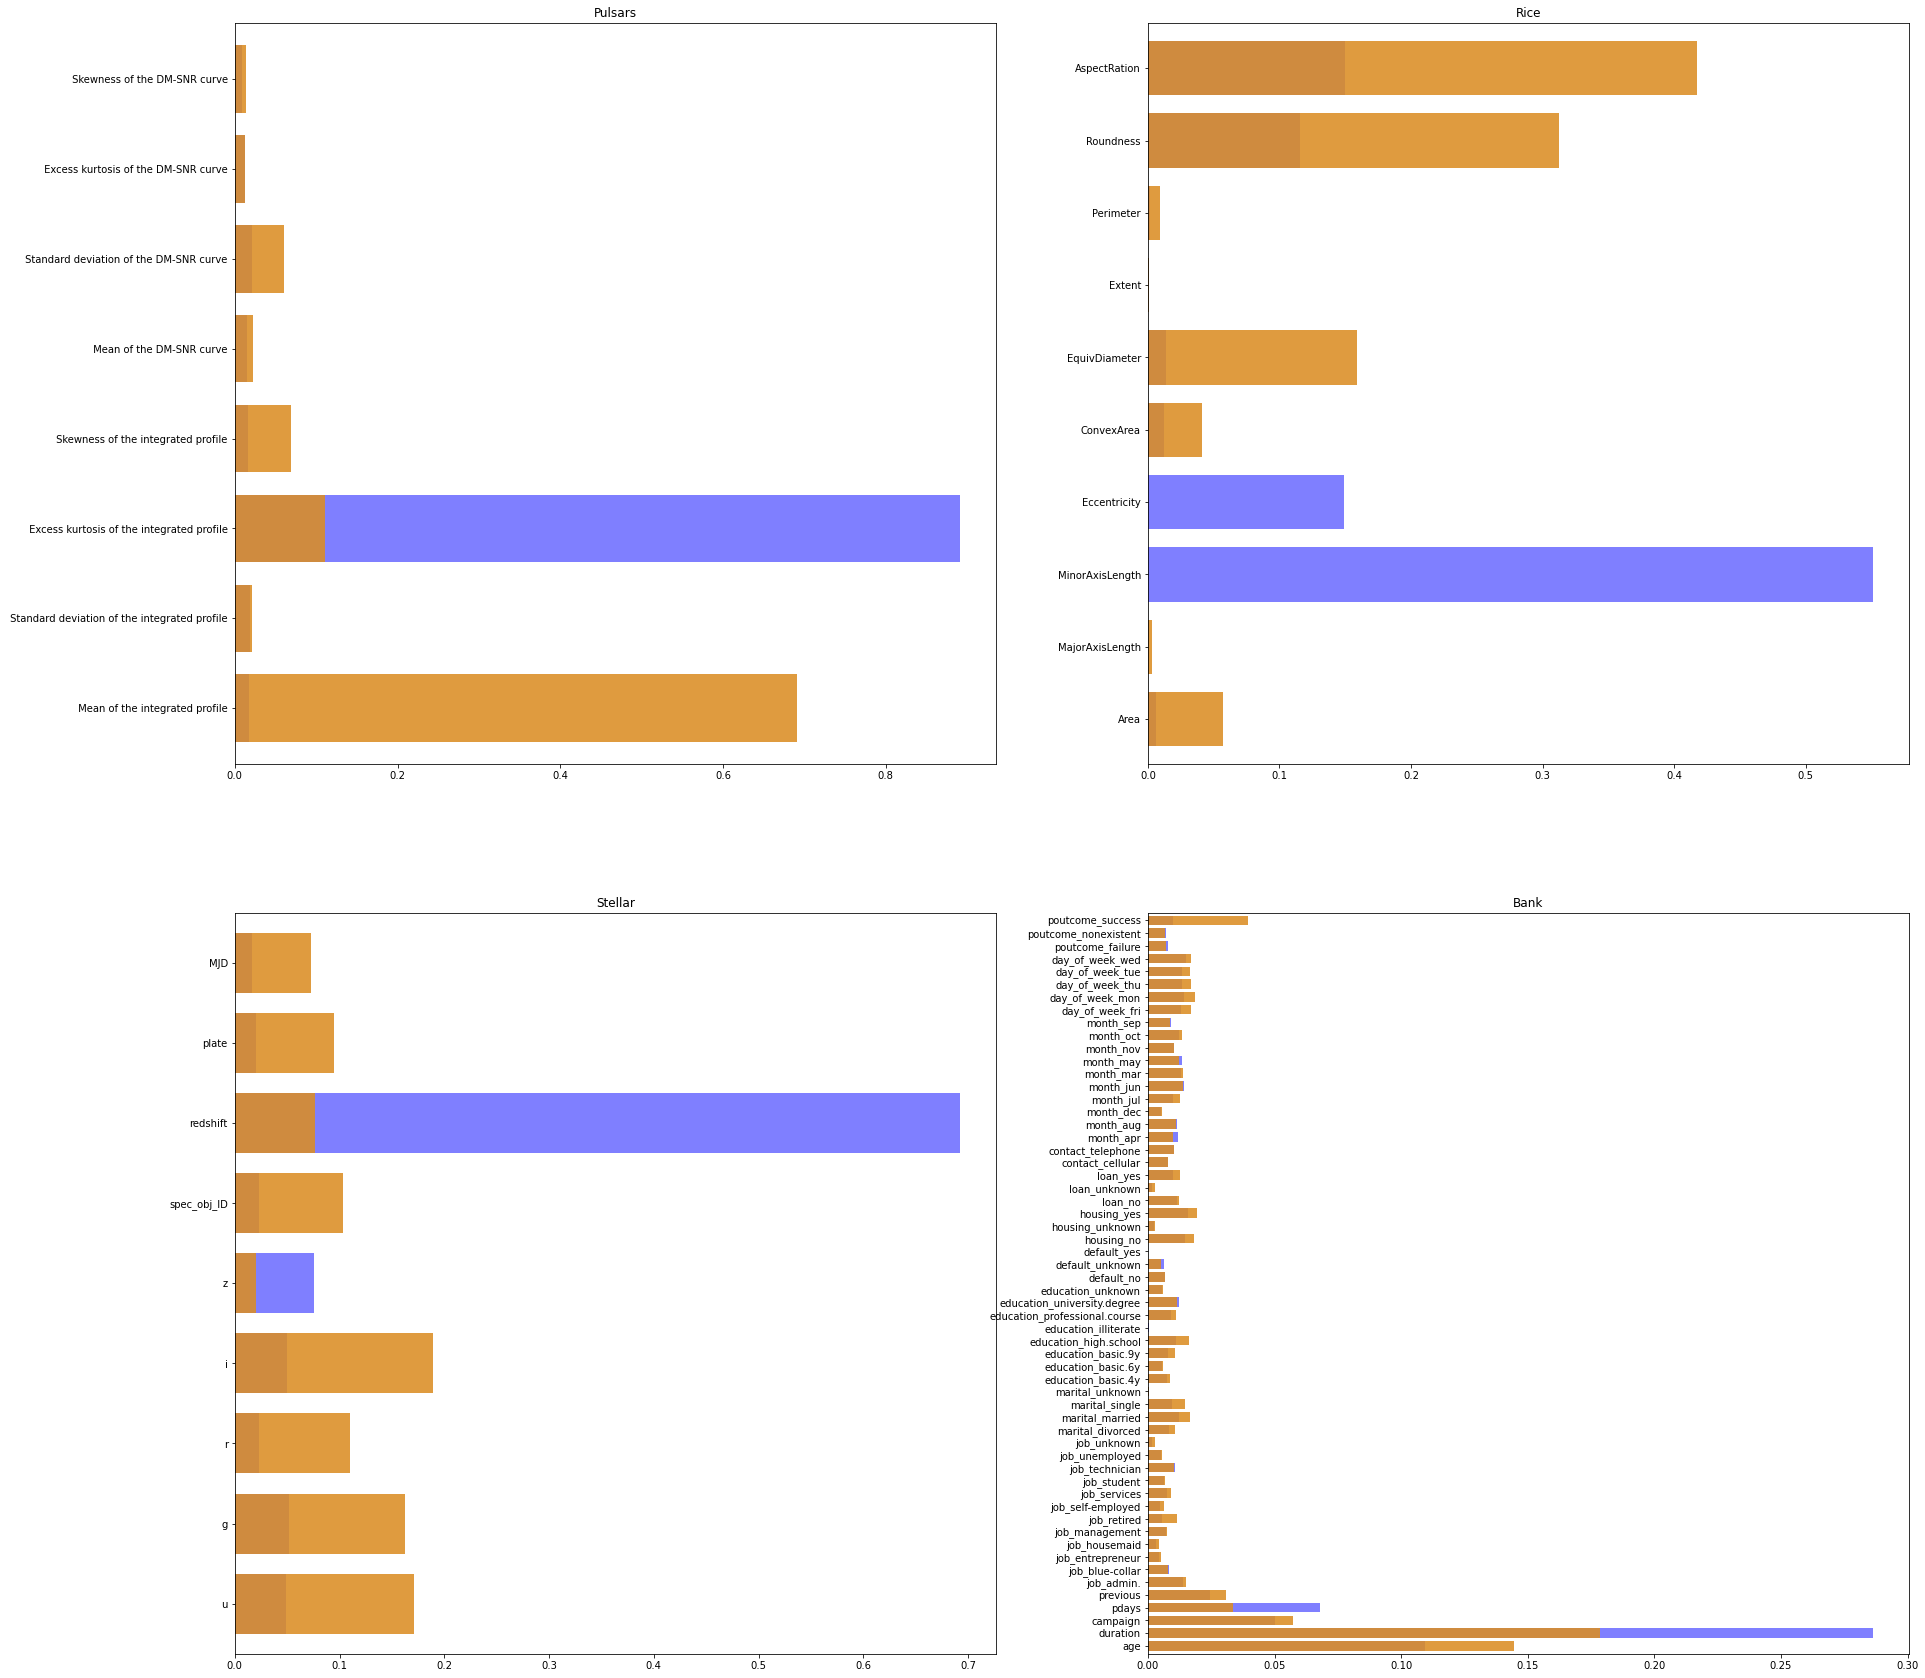

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(30,30))
axs = axs.flatten()


# IMPORTANCES = {0: {'Pulsars': {' Mean of the integrated profile': 0.014061834559798847, ' Standard deviation of the integrated profile': 0.01834979859188183, ' Excess kurtosis of the integrated profile': 0.808273572925474, ' Skewness of the integrated profile': 0.09322067226633822, ' Mean of the DM-SNR curve': 0.021685803619493408, ' Standard deviation of the DM-SNR curve': 0.022591165752916163, ' Excess kurtosis of the DM-SNR curve': 0.007957025581208406, ' Skewness of the DM-SNR curve': 0.013860126702889136}, 'Rice': {'Area': 0.039407671025862505, 'MajorAxisLength': 0.0007122272365083043, 'MinorAxisLength': 0.3340165745411449, 'Eccentricity': 0.32828374562940293, 'ConvexArea': 0.016860145419976595, 'EquivDiameter': 0.011958312023370662, 'Extent': 0.0006046641710593977, 'Perimeter': 0.003997851859759917, 'Roundness': 0.08693551371612364, 'AspectRation': 0.17722329437679116}, 'Stellar': {'u': 0.0463839560509145, 'g': 0.05815669337384569, 'r': 0.030341870005014284, 'i': 0.051410043783500343, 'z': 0.08185342521149783, 'spec_obj_ID': 0.02752656273357326, 'redshift': 0.6659903757694586, 'plate': 0.022871628147113934, 'MJD': 0.015465444925081536}, 'Bank': {'age': 0.11085666820143425, 'duration': 0.29910098724795553, 'campaign': 0.046729648891851217, 'pdays': 0.016943060587746483, 'previous': 0.021061307110344648, 'job_admin.': 0.012237560933962298, 'job_blue-collar': 0.009325766840237249, 'job_entrepreneur': 0.00509273853882297, 'job_housemaid': 0.0032751539402933543, 'job_management': 0.00855319552426213, 'job_retired': 0.005833667672198504, 'job_self-employed': 0.004865685350991323, 'job_services': 0.00663718741683512, 'job_student': 0.006763724809465674, 'job_technician': 0.00995309892621877, 'job_unemployed': 0.004231776301928741, 'job_unknown': 0.002769794384261709, 'marital_divorced': 0.008056568666745334, 'marital_married': 0.012664021967187364, 'marital_single': 0.009601959272113172, 'marital_unknown': 0.0003148659029080004, 'education_basic.4y': 0.006284597116160732, 'education_basic.6y': 0.005091796173532269, 'education_basic.9y': 0.008847718535088827, 'education_high.school': 0.012352996889313083, 'education_illiterate': 0.00037955391164891324, 'education_professional.course': 0.00926451734587843, 'education_university.degree': 0.013556762994637298, 'education_unknown': 0.00520702868073312, 'default_no': 0.004020864319876869, 'default_unknown': 0.005211652162422641, 'default_yes': 0.0, 'housing_no': 0.016463804091510527, 'housing_unknown': 0.0019215237628427938, 'housing_yes': 0.0162042597822191, 'loan_no': 0.010946297071547767, 'loan_unknown': 0.0017353933372525432, 'loan_yes': 0.011229485072447604, 'contact_cellular': 0.007628654679124952, 'contact_telephone': 0.01060195993800052, 'month_apr': 0.0101413284756085, 'month_aug': 0.010255966826036314, 'month_dec': 0.003757364258750867, 'month_jul': 0.009973040947869735, 'month_jun': 0.014943393508500213, 'month_mar': 0.013513623375407152, 'month_may': 0.012159817171221431, 'month_nov': 0.008567617981961751, 'month_oct': 0.013106148223260275, 'month_sep': 0.009231135971176587, 'day_of_week_fri': 0.0126512283104152, 'day_of_week_mon': 0.01453758116722442, 'day_of_week_thu': 0.01619602195260166, 'day_of_week_tue': 0.013599648785912124, 'day_of_week_wed': 0.013028391803676601, 'poutcome_failure': 0.007871427622844148, 'poutcome_nonexistent': 0.015443291292651203, 'poutcome_success': 0.04920566797288002}}, 5: {'Pulsars': {' Mean of the integrated profile': 0.006988819814256179, ' Standard deviation of the integrated profile': 0.008774110858249553, ' Excess kurtosis of the integrated profile': 0.7237039967030696, ' Skewness of the integrated profile': 0.21190018665537358, ' Mean of the DM-SNR curve': 0.011718824194187063, ' Standard deviation of the DM-SNR curve': 0.013592491809123133, ' Excess kurtosis of the DM-SNR curve': 0.015631631962477237, ' Skewness of the DM-SNR curve': 0.007689938003263603}, 'Rice': {'Area': 0.0005367715215196054, 'MajorAxisLength': 0.0008367874604169851, 'MinorAxisLength': 0.00038128726510811467, 'Eccentricity': 0.3086744688211511, 'ConvexArea': 0.0004910039048419143, 'EquivDiameter': 0.0005007365925594198, 'Extent': 0.02803767130909069, 'Perimeter': 0.0007857035016628225, 'Roundness': 0.6099468609311817, 'AspectRation': 0.04980870869246772}, 'Stellar': {'u': 0.029158551719154942, 'g': 0.029376334122994677, 'r': 0.0292262176054363, 'i': 0.029163118576153658, 'z': 0.030029525537060887, 'spec_obj_ID': 0.029306113360150685, 'redshift': 0.7664186523431923, 'plate': 0.028597656846790203, 'MJD': 0.02872382988906639}, 'Bank': {'age': 0.10194798311297526, 'duration': 0.09812034395196823, 'campaign': 0.10033290604079229, 'pdays': 0.10515057907665759, 'previous': 0.119827805528716, 'job_admin.': 0.009328496405078471, 'job_blue-collar': 0.008881012365469886, 'job_entrepreneur': 0.004304661310959652, 'job_housemaid': 0.0033381241576258464, 'job_management': 0.00679459083345625, 'job_retired': 0.008669539264568885, 'job_self-employed': 0.004305541660966252, 'job_services': 0.006616356308729103, 'job_student': 0.005918245404454206, 'job_technician': 0.009382093252834543, 'job_unemployed': 0.004259306839713475, 'job_unknown': 0.0020713066024822054, 'marital_divorced': 0.00764263458902847, 'marital_married': 0.010417097099602621, 'marital_single': 0.012427507320506829, 'marital_unknown': 0.0007368242835923036, 'education_basic.4y': 0.0061503702524827435, 'education_basic.6y': 0.004488100040320314, 'education_basic.9y': 0.007260504171881431, 'education_high.school': 0.011611822154625664, 'education_illiterate': 0.00012276479418001464, 'education_professional.course': 0.008387760920389346, 'education_university.degree': 0.011315762082313805, 'education_unknown': 0.005446343742078126, 'default_no': 0.007016483574209473, 'default_unknown': 0.002173218108783501, 'default_yes': 0.0, 'housing_no': 0.013149890861626287, 'housing_unknown': 0.0014266474626324801, 'housing_yes': 0.012246964323604895, 'loan_no': 0.010578611179725068, 'loan_unknown': 0.0019257082045956004, 'loan_yes': 0.008561872709067428, 'contact_cellular': 0.006736063725487196, 'contact_telephone': 0.009697252314554695, 'month_apr': 0.01045678810329075, 'month_aug': 0.010174236740265267, 'month_dec': 0.005285895170599485, 'month_jul': 0.010895617324157277, 'month_jun': 0.013106997738001572, 'month_mar': 0.011966944224715217, 'month_may': 0.01008284492308851, 'month_nov': 0.006342094885036916, 'month_oct': 0.012787992762165332, 'month_sep': 0.006903080078921628, 'day_of_week_fri': 0.012370921681177423, 'day_of_week_mon': 0.01114354003674205, 'day_of_week_thu': 0.012635189496786294, 'day_of_week_tue': 0.011364736505882567, 'day_of_week_wed': 0.012078596362312097, 'poutcome_failure': 0.010539990634675766, 'poutcome_nonexistent': 0.011820673378218988, 'poutcome_success': 0.06127476392122642}}}
# IMPORTANCES = {0: {'Pulsars': {' Mean of the integrated profile': 0.014440261640961944, ' Standard deviation of the integrated profile': 0.02381532340219969, ' Excess kurtosis of the integrated profile': 0.7446697485024802, ' Skewness of the integrated profile': 0.16271263652956983, ' Mean of the DM-SNR curve': 0.016357982866496288, ' Standard deviation of the DM-SNR curve': 0.018560145205447513, ' Excess kurtosis of the DM-SNR curve': 0.009548822056924002, ' Skewness of the DM-SNR curve': 0.009895079795920568}, 'Rice': {'Area': 0.040628027345191414, 'MajorAxisLength': 0.000943362314804511, 'MinorAxisLength': 0.3645288257511371, 'Eccentricity': 0.32596907680399506, 'ConvexArea': 0.01179772607914419, 'EquivDiameter': 0.015596438506466229, 'Extent': 0.00046162502125728, 'Perimeter': 0.001418019796660178, 'Roundness': 0.058902367097446125, 'AspectRation': 0.1797545312838979}, 'Heart Disease': {'BMI': 0.0017249886829305509, 'Smoking': 0.004599683806086171, 'AlcoholDrinking': 0.0, 'Stroke': 0.2606925746291453, 'PhysicalHealth': 0.0025312303307817746, 'MentalHealth': 0.0006727822715954762, 'DiffWalking': 0.3254321238997329, 'Sex': 0.04984441363201157, 'PhysicalActivity': 8.350533930098723e-05, 'SleepTime': 0.0006937371894056415, 'Asthma': 0.00021139662043499866, 'KidneyDisease': 0.02295167503302082, 'SkinCancer': 0.0012455658732421534, '0': 0.0, '1': 0.0, '2': 2.16560565170359e-05, '3': 0.00029497437028450015, '4': 6.831485554921189e-05, '5': 1.9105583909675065e-05, '6': 6.551050705513254e-05, '7': 8.594923114430858e-05, '8': 4.048494409917377e-05, '9': 0.00012216005472492057, '10': 0.0017287294391343604, '11': 0.03572312862826951, '12': 0.07855634664333422, '13': 0.0, '14': 0.0, '15': 0.0005042915982684583, '16': 0.0, '17': 0.0, '18': 0.0005727514215896247, '19': 0.00037078729183731964, '20': 0.011027260081615909, '21': 0.001306082457626153, '22': 0.057541206658612135, '23': 0.0036091551615087154, '24': 0.0024289669474206583, '25': 0.0, '26': 0.1352294607598108, '27': 0.0}, 'Stellar': {'u': 0.0193988600136831, 'g': 0.039993650337241705, 'r': 0.006203688842814598, 'i': 0.008105990928127863, 'z': 0.01973117941260075, 'spec_obj_ID': 0.004897371843503436, 'redshift': 0.8939814661430079, 'plate': 0.003766550973836802, 'MJD': 0.003921241505183965}}, 5: {'Pulsars': {' Mean of the integrated profile': 0.012620980858591441, ' Standard deviation of the integrated profile': 0.012813958932487024, ' Excess kurtosis of the integrated profile': 0.22678557531046534, ' Skewness of the integrated profile': 0.6561140818801366, ' Mean of the DM-SNR curve': 0.03619155739320526, ' Standard deviation of the DM-SNR curve': 0.028414337593022098, ' Excess kurtosis of the DM-SNR curve': 0.01208482549408237, ' Skewness of the DM-SNR curve': 0.014974682538009782}, 'Rice': {'Area': 0.16965030735501732, 'MajorAxisLength': 0.03066206662429414, 'MinorAxisLength': 0.14750656272929044, 'Eccentricity': 0.055224227852007104, 'ConvexArea': 0.22013238216839862, 'EquivDiameter': 0.06979583314230985, 'Extent': 0.05657238869695261, 'Perimeter': 0.04097409608288075, 'Roundness': 0.06304743844524119, 'AspectRation': 0.14643469690360797}, 'Heart Disease': {'BMI': 0.0006782213880194098, 'Smoking': 0.005092226224174915, 'AlcoholDrinking': 0.0, 'Stroke': 0.24796832224348067, 'PhysicalHealth': 0.0019501215379453458, 'MentalHealth': 0.0014438825041544344, 'DiffWalking': 0.34270971359899677, 'Sex': 0.047927369710237415, 'PhysicalActivity': 0.00011518141750692886, 'SleepTime': 0.0007156814775734174, 'Asthma': 0.0002544815438186281, 'KidneyDisease': 0.02992645580056988, 'SkinCancer': 0.0013489047226701815, '0': 0.0, '1': 0.0, '2': 0.0, '3': 0.00024290551268400746, '4': 2.568359572948603e-05, '5': 0.0, '6': 2.8981335726407496e-05, '7': 4.715496768166274e-05, '8': 3.0695509517474324e-05, '9': 0.0, '10': 0.00010768443733741981, '11': 0.03689943308487061, '12': 0.07672533721687314, '13': 2.911587605663152e-05, '14': 0.0, '15': 0.00046122719803874115, '16': 0.0, '17': 0.0, '18': 0.00025989811872739266, '19': 0.0006014834044641155, '20': 0.008299253260473021, '21': 0.0011978401205661716, '22': 0.05384542564106835, '23': 0.0056547470347791725, '24': 0.0025350377051406867, '25': 0.0, '26': 0.1328775338111176, '27': 0.0}, 'Stellar': {'u': 0.08564438112602533, 'g': 0.08614456353154552, 'r': 0.08514031731890374, 'i': 0.08588106666051078, 'z': 0.08501663802602492, 'spec_obj_ID': 0.09520108500165343, 'redshift': 0.29879487025258644, 'plate': 0.09396536587040208, 'MJD': 0.0842117122123478}}}
colors = ['blue', 'orange']

for DATA, ax in zip(DATASETS, axs.flatten()):

    name = DATA['name']

    imprtncs = [ IMPORTANCES[0][name], IMPORTANCES[5][name]]
    
    for i in range(2):
        fi = pd.Series(imprtncs[i].values(), index=imprtncs[i].keys())
        fi.plot(kind='barh', ax=ax, width=0.75, color=colors[i], alpha=0.5)

        noise = 1
        fi = pd.Series(imprtncs[noise].values(), index=imprtncs[noise].keys())
        fi.plot(kind='barh', ax=ax, width=0.75, color=colors[i], alpha=0.5)

        ax.set_title(name)